In [25]:
import pandas as pd #imported relevant packages
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [26]:
wall_st = pd.read_csv('wallstreetbets.csv') #loading data
gambling = pd.read_csv('gambling.csv');

In [27]:
gambling = gambling[['body']] # extracting correct columns
wall_st = wall_st[['body']]

In [28]:
gambling['subreddit'] = 'gambling' # adding target variable
wall_st['subreddit'] = 'wall_st'

In [29]:
data = pd.concat([gambling, wall_st], axis = 0) # concat DataFrame

In [30]:
data['subreddit'] = data['subreddit'].map({'wall_st': 1, 'gambling' : 0}) # converting target variable to binary outcome

In [31]:
data.rename(columns = {'body' : 'text', 'subreddit' : 'gambling'}, inplace = True) # renameing columns

In [32]:
X = data['text'] # converting to X variable
y = data['gambling'] # converting to y variable

## Prep Data For Random Forrest

In [33]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X,  #train test split
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [34]:
# setting up count vectorizer
cvec = CountVectorizer(stop_words = 'english', max_df = 0.9, max_features = 4000, min_df = 2, ngram_range = (1, 1))

In [35]:
train_raw_rf = cvec.fit_transform(X_train_rf) # transform data into a sparse data type

In [36]:
train_df_rf = pd.DataFrame.sparse.from_spmatrix(train_raw_rf, columns=cvec.get_feature_names()) # converting to dataframe

## Prep Data For Logistic Regression

In [37]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X,  #train test split
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [38]:
# setting up count vectorizer
cvec = CountVectorizer(stop_words = 'english', max_df = 0.9, max_features = 4000, min_df = 2, ngram_range = (1, 1)) # 

In [39]:
train_raw_lr = cvec.fit_transform(X_train_lr) # transform data into a sparse data type

In [40]:
train_df_lr = pd.DataFrame.sparse.from_spmatrix(train_raw_lr, columns=cvec.get_feature_names()) # converting to dataframe

## Random Forest Classifier Process

In [41]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X,  #train test split
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [42]:
pipe = Pipeline([ 
    ('cvec', CountVectorizer(stop_words = 'english')),
    ('rf', RandomForestClassifier())  # setting up pipeline
])

In [43]:
pipe_params = {
    'cvec__max_features' : [3000, 4000], # pipe parameters
    'cvec__min_df' : [2, 3],
    'cvec__max_df' : [0.9],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'rf__n_estimators' : [100]
}

In [44]:
gs = GridSearchCV(pipe,
                  pipe_params, # setting up grid search
                  cv = 5)

In [45]:
gs.fit(X_train_rf, y_train_rf); # fitting the model

In [46]:
print(f'Train score is {gs.score(X_train_rf, y_train_rf)}') # scoring
print(f'Test score is {gs.score(X_test_rf, y_test_rf)}')    # nice looks like there's no overfitting

Train score is 0.9861791044776119
Test score is 0.9838787878787879


In [47]:
gs.best_params_ # best parameters for random forest

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'rf__n_estimators': 100}

In [48]:
fi = gs.best_estimator_.named_steps['rf'].feature_importances_

In [49]:
features_df = pd.DataFrame(fi, train_df_rf.columns, columns = ['importance'])

In [50]:
barplot = features_df.sort_values(by = 'importance', ascending = False).head(10) # most important features

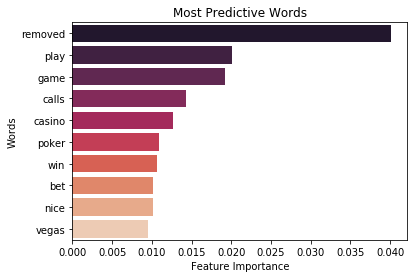

In [51]:
sns.barplot(y = barplot.index, x = barplot['importance'], orient = 'h', palette="rocket")
plt.xlabel('Feature Importance')
plt.ylabel('Words')
plt.title('Most Predictive Words');

## Logistic Regression Process

In [52]:
pipe_2 = Pipeline([ 
    ('cvec', CountVectorizer(stop_words = 'english')),
    ('lr', LogisticRegression(solver = 'liblinear'))  # setting up pipeline
])

In [53]:
pipe_params_2 = {
    'cvec__max_features' : [3000, 4000], # pipe parameters
    'cvec__min_df' : [1, 2, 3],
    'cvec__max_df' : [0.9],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'lr__C' : [1, 2]
    
}

In [54]:
gs_2 = GridSearchCV(pipe_2,
                  pipe_params_2, # setting up grid search
                  cv = 5)

In [55]:
gs_2.fit(X_train_lr, y_train_lr); # fitting the model

In [56]:
print(f'Train score is {gs_2.score(X_train_lr, y_train_lr)}') # scoring
print(f'Test score is {gs_2.score(X_test_lr, y_test_lr)}')    # nice looks like there's no overfitting

Train score is 0.9850149253731343
Test score is 0.982909090909091


In [57]:
gs_2.best_params_ # best parameters

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'lr__C': 1}

## Score Comparision DataFrame

In [58]:
lr = gs_2.score(X_test_lr, y_test_lr)
rf = gs.score(X_test_rf, y_test_rf)

In [59]:
viz = pd.DataFrame({'test_score': [lr, rf], 'model': ['Logistic Regression', 'Random Forest']})

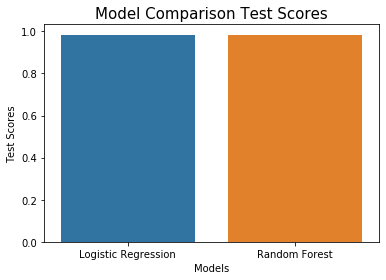

In [60]:
sns.barplot(x="model", y="test_score", data=viz,  palette=None)
plt.ylabel('Test Scores')
plt.xlabel('Models')
plt.title('Model Comparison Test Scores', fontsize=15);

In [61]:
viz

,test_score,model
0,0.982909,Logistic Regression
1,0.983879,Random Forest


In [62]:
lr2 = gs_2.score(X_train_lr, y_train_lr)
rf2 = gs.score(X_train_rf, y_train_rf)

In [63]:
viz2 = pd.DataFrame({'train_score': [lr2, rf2], 'model': ['Logistic Regression', 'Random Forest']})

In [64]:
viz2

,train_score,model
0,0.985015,Logistic Regression
1,0.986179,Random Forest


## Word Count: Gambling

In [65]:
cvec5 = CountVectorizer(stop_words = 'english', max_df = 0.9, max_features = 4000, min_df = 2, ngram_range = (1, 1))
word_count = cvec5.fit_transform(gambling['body']) # transform data into a sparse data type

In [66]:
gambling_wc = pd.DataFrame.sparse.from_spmatrix(word_count, columns=cvec5.get_feature_names()) # converting to dataframe

In [67]:
gam = pd.DataFrame(gambling_wc.sum().sort_values(ascending = False).head(20))

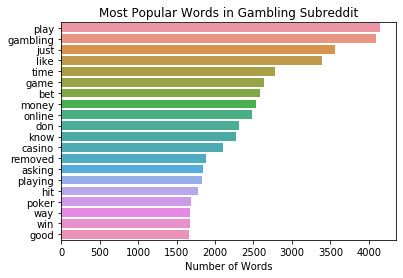

In [68]:
sns.barplot(data = gam, x = gam[0], y = gam.index)
plt.xlabel('Number of Words')
plt.title('Most Popular Words in Gambling Subreddit');

## Word Count: Wall Street Bets

In [69]:
cvec6 = CountVectorizer(stop_words = 'english', max_df = 0.9, max_features = 4000, min_df = 2, ngram_range = (1, 1))
word_count2 = cvec6.fit_transform(wall_st['body']) # transform data into a sparse data type

In [70]:
wallst_wc = pd.DataFrame.sparse.from_spmatrix(word_count2, columns=cvec6.get_feature_names()) # converting to dataframe

In [71]:
wall = pd.DataFrame(wallst_wc.sum().sort_values(ascending = False).head(20))

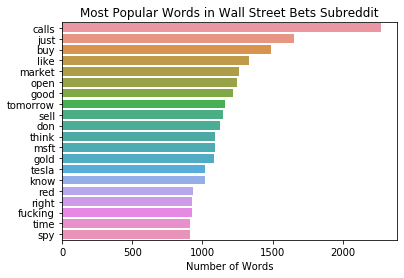

In [72]:
sns.barplot(data = wall, x = wall[0], y = wall.index)  # word count for wall st bets
plt.xlabel('Number of Words')
plt.title('Most Popular Words in Wall Street Bets Subreddit');